<h1 style= "text-align: center;"> Loan Default Prediction</h1>
<h5 style= "text-align: center;">Predicting loan defaults using machine learning</h5>
<h5 style= "text-align: center;">Data set from Kaggle: <a href = "https://www.kaggle.com/datasets/nikhil1e9/loan-default?utm_source=chatgpt.com"> Click Here</a></h5>

In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling and preprocessing
from sklearn.preprocessing import StandardScaler

# Handling imbalanced data;
from imblearn.over_sampling import SMOTE

# Train-Test split
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Ignoring warnings
import warnings 
warnings.filterwarnings('ignore')


In [13]:
df = pd.read_csv("Loan_default.csv")
df.head()

LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1      Full-time       Married          No            No       Other   
2     Unemployed      Divorced         Yes           Yes        Auto   
3      Full-time       Married          No            No    Business   
4     Unemployed      Divorced          No           Yes        Auto   

  HasCoSigner  Default  
0         Yes        0  
1         Yes        0  
2          No        1  
3          No        0  
4          No        0

# Initial Dataset Columns Overview

## Column Descriptions
- **LoanID**: Unique identifier for each loan (Categorical - `object`).
- **Age**: Age of the borrower (Numerical - `int64`).
- **Income**: Annual income of the borrower (Numerical - `int64`).
- **LoanAmount**: Amount of the loan (Numerical - `int64`).
- **CreditScore**: Credit score of the borrower (Numerical - `int64`).
- **MonthsEmployed**: Number of months the borrower has been employed (Numerical - `int64`).
- **NumCreditLines**: Number of active credit lines (Numerical - `int64`).
- **InterestRate**: Interest rate for the loan (Numerical - `float64`).
- **LoanTerm**: Term of the loan in months (Numerical - `int64`).
- **DTIRatio**: Debt-to-Income ratio (Numerical - `float64`).
- **Education**: Borrower's level of education (Categorical - `object`).
- **EmploymentType**: Type of employment (Categorical - `object`).
- **MaritalStatus**: Marital status of the borrower (Categorical - `object`).
- **HasMortgage**: Indicates whether the borrower has a mortgage (`Yes`/`No`) (Categorical - `object`).
- **HasDependents**: Indicates whether the borrower has dependents (`Yes`/`No`) (Categorical - `object`).
- **LoanPurpose**: Purpose of the loan (e.g., `Auto`, `Education`, `Home`) (Categorical - `object`).
- **HasCoSigner**: Indicates whether there is a co-signer for the loan (`Yes`/`No`) (Categorical - `object`).
- **Default**: Target variable indicating whether the borrower defaulted on the loan (`0` = No, `1` = Yes) (Numerical - `int64`).

---

## Column Types
- **Numerical Columns**: 10
  - Age, Income, LoanAmount, CreditScore, MonthsEmployed, NumCreditLines, InterestRate, LoanTerm, DTIRatio, Default.
- **Categorical Columns**: 8
  - LoanID, Education, EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner.
- **Target Variable**: `Default` column is binary:
    - 0: The borrower did not default (loan is repaid as scheduled).
    - 1: The borrower defaulted (failed to meet repayment terms).

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

## Data Quality
- **Missing Values**: None (all columns have complete data).
- **Duplicates**: Removed using `df.drop_duplicates()`.
- **Outliers**: No significant outliers detected in the numerical columns based on boxplots.

In [19]:
# Check for null alues
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [21]:
# Drop Duplicates
df = df.drop_duplicates()

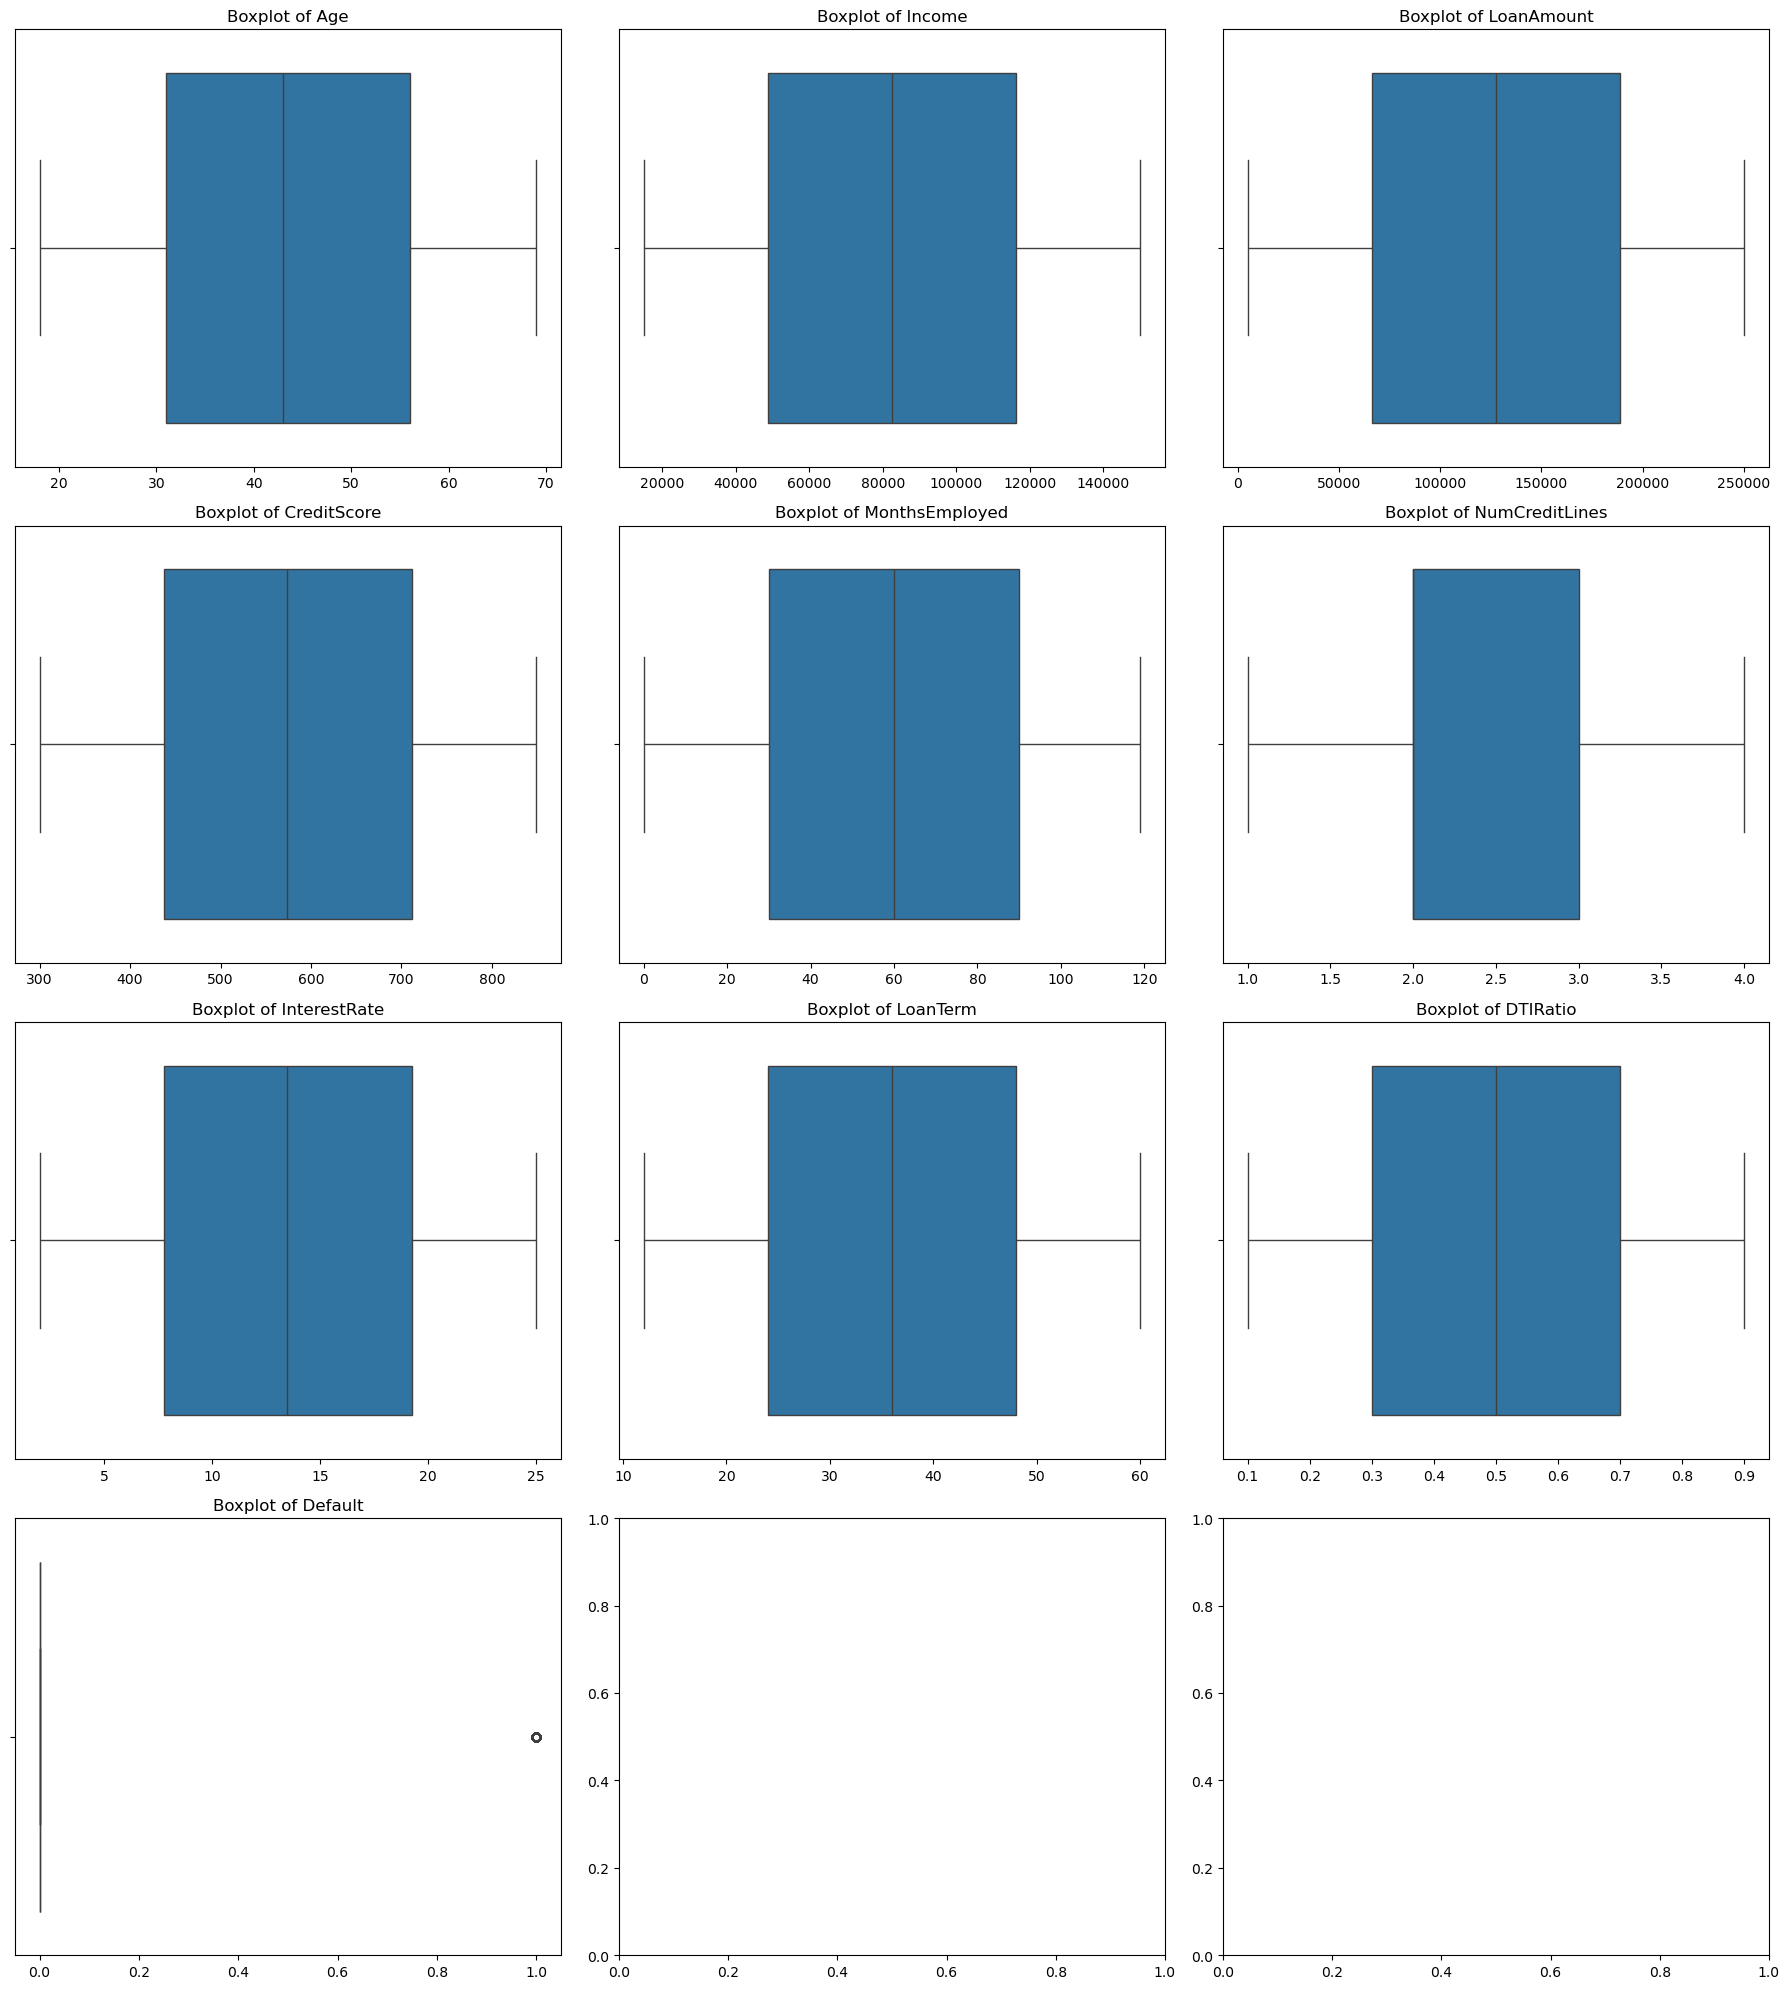

In [22]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure size and layout
num_cols = len(numerical_columns)
rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate rows for a 3-column layout

fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))  # Adjust grid and size
axes = axes.flatten()  # Flatten axes for easy iteration

# Create boxplots
for i, column in enumerate(numerical_columns):
    sns.boxplot(ax=axes[i], x=df[column])
    axes[i].set_title(f"Boxplot of {column}")
    axes[i].set_xlabel("") 

# Adjust layout
plt.tight_layout()
plt.show()

## Unique Values in Categorical Features
- **LoanID**: Unique for every record.
- **Education**: ["Bachelor's", "Master's", "High School", "PhD"]
- **EmploymentType**: ['Full-time', 'Unemployed', 'Self-employed', 'Part-time']
- **MaritalStatus**: ['Divorced', 'Married', 'Single']
- **HasMortgage**: ['Yes', 'No']
- **HasDependents**: ['Yes', 'No']
- **LoanPurpose**: ['Other', 'Auto', 'Business', 'Home', 'Education']
- **HasCoSigner**: ['Yes', 'No']


In [25]:
# Select only the columns with dtype 'object'
object_columns = df.select_dtypes(include=['object'])

# Iterate through the object columns and print unique values
for column in object_columns.columns:
    print(f"Unique values in column '{column}':")
    print(df[column].unique())
    print("-" * 50)
    print("\n")

Unique values in column 'LoanID':
['I38PQUQS96' 'HPSK72WA7R' 'C1OZ6DPJ8Y' ... 'XQK1UUUNGP' 'JAO28CPL4H'
 'ZTH91CGL0B']
--------------------------------------------------


Unique values in column 'Education':
["Bachelor's" "Master's" 'High School' 'PhD']
--------------------------------------------------


Unique values in column 'EmploymentType':
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
--------------------------------------------------


Unique values in column 'MaritalStatus':
['Divorced' 'Married' 'Single']
--------------------------------------------------


Unique values in column 'HasMortgage':
['Yes' 'No']
--------------------------------------------------


Unique values in column 'HasDependents':
['Yes' 'No']
--------------------------------------------------


Unique values in column 'LoanPurpose':
['Other' 'Auto' 'Business' 'Home' 'Education']
--------------------------------------------------


Unique values in column 'HasCoSigner':
['Yes' 'No']
-------------

In [26]:
df.describe()

Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000        2.000000       7.770000      24.000000   
50%         60.000000        2.000000      13.460000      36.000000   
75%         90.000000        3.000000      19.250000      48.000000   
max        119.000000        4.000000      25.000000      60.000000   

            DTIRatio        Default  
count  255347.000000  255347.000000  
mean        0.500212       0.116128  
std         0.230917       0.320379  
min         0.100000       0.000000  
25%         0.300000       0.000000  
50%         0.500000       0.000000  
75%         0.700000       0.000000  
max         0.900000       1.000000

## Correlation Analysis
- **Key Insights**:
  - No strong linear correlations observed between numerical features (all correlations are close to 0).
  - This indicates minimal redundancy between features based on linear relationships.
  - Non-linear relationships may still exist and should be investigated further.

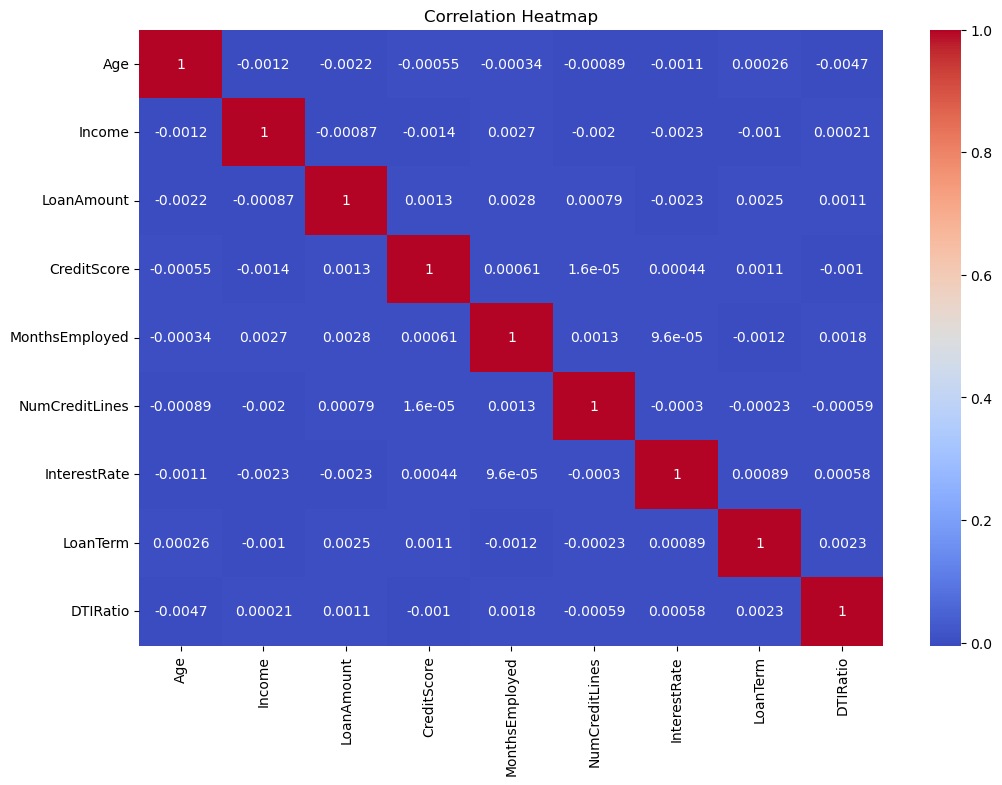

In [28]:
# Correlation heatmap
corr_matrix = df[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## Target Variable Distribution
- **Class Distribution**:
  - **Non-Default (`0`)**: 88.39%
  - **Default (`1`)**: 11.61%
- **Observation**: The dataset is imbalanced, with a majority of loans categorized as `non-default`.

In [30]:
# Counting percentage in the default
df['Default'].value_counts(normalize=True) * 100

Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64

## Data Preprocessing
- **One-Hot Encoding**:
  - Categorical columns (`Education`, `EmploymentType`, `MaritalStatus`, etc.) were one-hot encoded using `drop_first=True` to avoid multicollinearity.
- **Feature Engineering**:
  - Added new derived features:
    - `Income-to-Loan Ratio`: Ratio of `Income` to `LoanAmount`.
    - `Debt-to-Income Ratio`: Ratio of `LoanAmount` to `Income`.
- **Scaling**:
  - Standardized numerical columns (`Age`, `Income`, `LoanAmount`, etc.) along with newly created features (`Income-to-Loan Ratio` and `Debt-to-Income Ratio`) using `StandardScaler`.
- **Class Imbalance Handling**:
  - Used **SMOTE (Synthetic Minority Oversampling Technique)** to balance the `Default` target variable.
  - Ensures both classes (`Default = 0` and `Default = 1`) have equal representation in the training dataset.
- **Train-Test Split**:
  - Split the preprocessed dataset into training (70%) and testing (30%) sets.

---

One-Hot Encoding:

In [34]:
df_encoded = pd.get_dummies(df, columns=['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'], drop_first=True)
# Drop the first category from each categorical column to avoid redundancy and multicollinearity.

In [35]:
df_encoded.dtypes

LoanID                           object
Age                               int64
Income                            int64
LoanAmount                        int64
CreditScore                       int64
MonthsEmployed                    int64
NumCreditLines                    int64
InterestRate                    float64
LoanTerm                          int64
DTIRatio                        float64
Default                           int64
Education_High School              bool
Education_Master's                 bool
Education_PhD                      bool
EmploymentType_Part-time           bool
EmploymentType_Self-employed       bool
EmploymentType_Unemployed          bool
MaritalStatus_Married              bool
MaritalStatus_Single               bool
HasMortgage_Yes                    bool
HasDependents_Yes                  bool
LoanPurpose_Business               bool
LoanPurpose_Education              bool
LoanPurpose_Home                   bool
LoanPurpose_Other                  bool


---

Scaling:

In [38]:
# Select numerical columns
numerical_columns = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                     'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Apply Standard Scaling
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

print("Numerical columns successfully scaled!")


Numerical columns successfully scaled!


---

Feature Engineering:

In [41]:
# Create Income-to-Loan Ratio
df_encoded['Income_to_Loan_Ratio'] = df['Income'] / df['LoanAmount']

print("Feature 'Income_to_Loan_Ratio' added!")


Feature 'Income_to_Loan_Ratio' added!


In [42]:
# Create Debt-to-Income Ratio (DTIRatio already exists, but here’s the formula for reference)
# Assuming DTIRatio = LoanAmount / Income
df_encoded['Debt_to_Income_Ratio'] = df['LoanAmount'] / df['Income']

print("Feature 'Debt_to_Income_Ratio' added!")


Feature 'Debt_to_Income_Ratio' added!


---

Imbalancing:

In [45]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   LoanID                        255347 non-null  object 
 1   Age                           255347 non-null  float64
 2   Income                        255347 non-null  float64
 3   LoanAmount                    255347 non-null  float64
 4   CreditScore                   255347 non-null  float64
 5   MonthsEmployed                255347 non-null  float64
 6   NumCreditLines                255347 non-null  float64
 7   InterestRate                  255347 non-null  float64
 8   LoanTerm                      255347 non-null  float64
 9   DTIRatio                      255347 non-null  float64
 10  Default                       255347 non-null  int64  
 11  Education_High School         255347 non-null  bool   
 12  Education_Master's            255347 non-nul

In [47]:
# Drop non-numerical columns (e.g., LoanID) from X
X = df_encoded.drop(columns=['LoanID', 'Default'])  # Drop target and identifier columns
y = df_encoded['Default']

# Check if all columns in X are numerical
print(X.dtypes)

Age                             float64
Income                          float64
LoanAmount                      float64
CreditScore                     float64
MonthsEmployed                  float64
NumCreditLines                  float64
InterestRate                    float64
LoanTerm                        float64
DTIRatio                        float64
Education_High School              bool
Education_Master's                 bool
Education_PhD                      bool
EmploymentType_Part-time           bool
EmploymentType_Self-employed       bool
EmploymentType_Unemployed          bool
MaritalStatus_Married              bool
MaritalStatus_Single               bool
HasMortgage_Yes                    bool
HasDependents_Yes                  bool
LoanPurpose_Business               bool
LoanPurpose_Education              bool
LoanPurpose_Home                   bool
LoanPurpose_Other                  bool
HasCoSigner_Yes                    bool
Income_to_Loan_Ratio            float64


In [50]:
# Apply SMOTE
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class imbalance handled using SMOTE!")
print("New class distribution:")
print(y_resampled.value_counts())

Class imbalance handled using SMOTE!
New class distribution:
Default
0    225694
1    225694
Name: count, dtype: int64


In [51]:
# checking sizes before and after resampling
print("Original dataset size:", df_encoded.shape)
print("Original target distribution:")
print(y.value_counts())
print("-" * 50)
print("Resampled dataset size:", X_resampled.shape)
print("Resampled target distribution:")
print(y_resampled.value_counts())



Original dataset size: (255347, 28)
Original target distribution:
Default
0    225694
1     29653
Name: count, dtype: int64
--------------------------------------------------
Resampled dataset size: (451388, 26)
Resampled target distribution:
Default
0    225694
1    225694
Name: count, dtype: int64


---

Train-Test Split:

In [56]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

print("Train-test split completed!")
print(f"Training samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")


Train-test split completed!
Training samples: 315971
Testing samples: 135417


---

---

<h1 style="text-align: center;">Machine Learning</h1>


---

##### Logistic Regression:

In [69]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_logreg = log_reg.predict(X_test)
y_proba_logreg = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_logreg))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     67673
           1       0.75      0.75      0.75     67744

    accuracy                           0.75    135417
   macro avg       0.75      0.75      0.75    135417
weighted avg       0.75      0.75      0.75    135417

Confusion Matrix:
[[50312 17361]
 [16852 50892]]
ROC-AUC Score: 0.8286179340643491


----

###### Random Forest

In [77]:
import time
from sklearn.ensemble import RandomForestClassifier

# Sample code for timing
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Start timer
start_time = time.time()

# Fit the model
rf.fit(X_train, y_train)

# End timer
end_time = time.time()

print(f"Random Forest training completed in {end_time - start_time:.2f} seconds.")


Random Forest training completed in 123.03 seconds.


In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     67673
           1       0.92      0.93      0.92     67744

    accuracy                           0.92    135417
   macro avg       0.92      0.92      0.92    135417
weighted avg       0.92      0.92      0.92    135417

Confusion Matrix:
[[61977  5696]
 [ 4929 62815]]
ROC-AUC Score: 0.9765483338741308


---

###### XGBoost

In [81]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     67673
           1       0.97      0.85      0.91     67744

    accuracy                           0.91    135417
   macro avg       0.92      0.91      0.91    135417
weighted avg       0.92      0.91      0.91    135417

Confusion Matrix:
[[66148  1525]
 [10485 57259]]
ROC-AUC Score: 0.957447112895963


---

##### Model Performance

In [84]:
# Summary of ROC-AUC Scores
roc_auc_scores = {
    "Logistic Regression": roc_auc_score(y_test, y_proba_logreg),
    "Random Forest": roc_auc_score(y_test, y_proba_rf),
    "XGBoost": roc_auc_score(y_test, y_proba_xgb),
}

print("Model ROC-AUC Scores:")
for model, score in roc_auc_scores.items():
    print(f"{model}: {score:.4f}")


Model ROC-AUC Scores:
Logistic Regression: 0.8286
Random Forest: 0.9765
XGBoost: 0.9574


---

##### Model Visualization

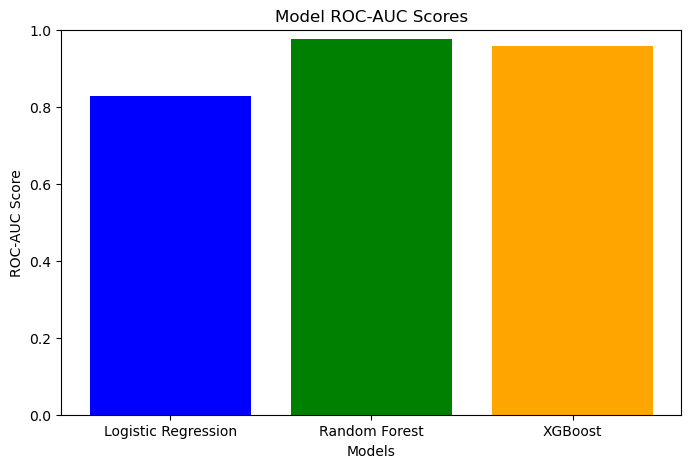

In [87]:
# Plot ROC-AUC Scores
models = list(roc_auc_scores.keys())
scores = list(roc_auc_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(models, scores, color=['blue', 'green', 'orange'])
plt.title("Model ROC-AUC Scores")
plt.xlabel("Models")
plt.ylabel("ROC-AUC Score")
plt.ylim(0, 1)
plt.show()
